In [42]:
import json
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load JSON file
with open("./iris_templates/iris_template_pooled_maxpool_mask.json", "r") as f:
    data = json.load(f)


In [43]:
data

[{'folder': '0000',
  'filename': '0000_000.bmp',
  'eye_side': 'left',
  'iris_template': {'iris_codes': '11111000010101111111111001011111100111111110011111101111111010100000011111100101111111111111101010101010100000000001011111111010011111101010101010101010100000111110000001011111111000010111111010000001010111110101111111111001010101011111111111010101111111111111111101010111111111111111111000010111111001111111101001111110100000010101011111111111111110101010101010000111101011111010111111111110101010101010101010101010100001010101111111111110010111111010010101111111010111111101111111111110010111111111111111100101111111010101111111111111111111101010000001011111111010011111100001010111111111101111111000011111101010000101111110101000111110101000011110101010101011111110101000001010011111100001010111111111111010010101111111100101011111111110100000010111111111111111011111111001011111111011111101011111111110100001111110000101111111101010000101011111111010000001000001111111101111101000111111111

Load and reshape templates

In [44]:
import numpy as np

# === Parameters ===
TARGET_SHAPE = (2, 8, 128, 2)  # Change this as needed
EXPECTED_BITS = np.prod(TARGET_SHAPE)  # = 2 * 16 * 256 * 2 = 16384

# === Utility Functions ===

def bitstring_to_array(bitstring):
    """Convert string of '0' and '1' to uint8 NumPy array."""
    return np.array([int(b) for b in bitstring], dtype=np.uint8)

def reshape_iris_code(flat_array, shape):
    """Reshape flat array to desired shape."""
    expected_size = np.prod(shape)
    if flat_array.size != expected_size:
        raise ValueError(f"Expected {expected_size} bits, got {flat_array.size}")
    return flat_array.reshape(shape)

# === Load and reshape templates ===

samples = []
bad_entries = 0

for idx, entry in enumerate(data):
    try:
        iris_template = entry.get("iris_template", {})
        iris_codes_raw = iris_template.get("iris_codes")
        mask_codes_raw = iris_template.get("mask_codes")

        if not iris_codes_raw or not mask_codes_raw:
            raise ValueError("Missing iris_codes or mask_codes")

        iris_codes = bitstring_to_array(iris_codes_raw)
        mask_codes = bitstring_to_array(mask_codes_raw)

        iris_codes = reshape_iris_code(iris_codes, TARGET_SHAPE)
        mask_codes = reshape_iris_code(mask_codes, TARGET_SHAPE)

        samples.append((iris_codes, mask_codes))

    except Exception as e:
        print(f"[Warning] Skipping entry {idx} due to error: {e}")
        samples.append(None)  # Keep index aligned
        bad_entries += 1

print(f"✅ Loaded {len(samples) - bad_entries} valid samples. Skipped {bad_entries} bad entries.")


[Warning] Skipping entry 148 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 149 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 155 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 239 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 280 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 281 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 282 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 283 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 284 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 285 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 286 due to error: 'NoneType' object has no attribute 'get'
[Warning] Skipping entry 287 due to error: 'NoneType' object has no attribut

Visualize the sample

In [45]:
def visualize_iris_code(data, mask_arr):
    """
    Visualizes the iris code and its mask.
    data: (2, 8, 128, 2) iris code
    mask_arr: (2, 8, 128, 2) mask array
    """
    fig, axes = plt.subplots(4, 1, figsize=(12, 6))

    titles = [
        "(0,0)  # filter 0, real",
        "(0,1)  # filter 0, imaginary",
        "(1,0)  # filter 1, real",
        "(1,1)  # filter 1, imaginary",
    ]

    for i, (filter_idx, channel_idx) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
        image = data[filter_idx, :, :, channel_idx]
        mask = mask_arr[filter_idx, :, :, channel_idx]

        axes[i].imshow(image, cmap="gray", aspect="auto")
        axes[i].imshow(1 - mask, cmap="Reds", alpha=0.3, aspect="auto")  # Invalid = red
        axes[i].set_title(titles[i])
        axes[i].axis("off")

    plt.subplots_adjust(hspace=0.6)
    plt.show()

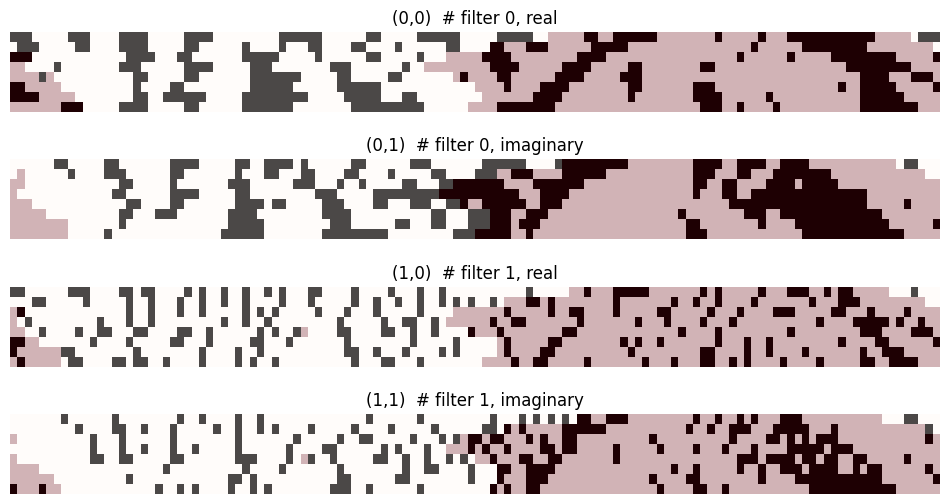

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a sample to visualize
sample_idx = 100 # Change this to 1 or 2 for other samples
iris_code, mask_arr = samples[sample_idx]

visualize_iris_code(iris_code, mask_arr)


Calculate hamming distance matrix

In [47]:
### Calculate hamming distance matrix ###
import numpy as np
from tqdm import tqdm

# === Assumes `samples` has length 1200 and includes None for invalids ===
n = len(samples)
distance_matrix = np.full((n, n), fill_value=np.nan, dtype=np.float32)

for i in tqdm(range(n), desc="Computing Hamming distances"):
    if samples[i] is None:
        continue  # Skip invalid template

    template1, mask1 = samples[i]
    for j in range(i + 1, n):
        if samples[j] is None:
            continue  # Skip invalid comparison

        template2, mask2 = samples[j]
        min_distance = 1.0

        for shift in range(-7, 8):
            t2_shifted = np.roll(template2, shift=shift, axis=2)
            m2_shifted = np.roll(mask2, shift=shift, axis=2)

            xor_real = template1[..., 0] ^ t2_shifted[..., 0]
            xor_imag = template1[..., 1] ^ t2_shifted[..., 1]

            valid_mask_real = mask1[..., 0] & m2_shifted[..., 0]
            valid_mask_imag = mask1[..., 1] & m2_shifted[..., 1]

            masked_xor_real = xor_real & valid_mask_real
            masked_xor_imag = xor_imag & valid_mask_imag

            num_diff = np.sum(masked_xor_real) + np.sum(masked_xor_imag)
            num_valid = np.sum(valid_mask_real) + np.sum(valid_mask_imag)

            if num_valid != 0:
                distance = num_diff / num_valid
                if distance < min_distance:
                    min_distance = distance

        # Save symmetric value
        distance_matrix[i, j] = min_distance
        distance_matrix[j, i] = min_distance

# Save result
np.save("hamming_distance_matrix.npy", distance_matrix)
print("✅ Distance matrix saved to 'hamming_distance_matrix.npy'")


Computing Hamming distances: 100%|██████████| 1200/1200 [13:32<00:00,  1.48it/s]

✅ Distance matrix saved to 'hamming_distance_matrix.npy'


Visualize hamming distance matrix

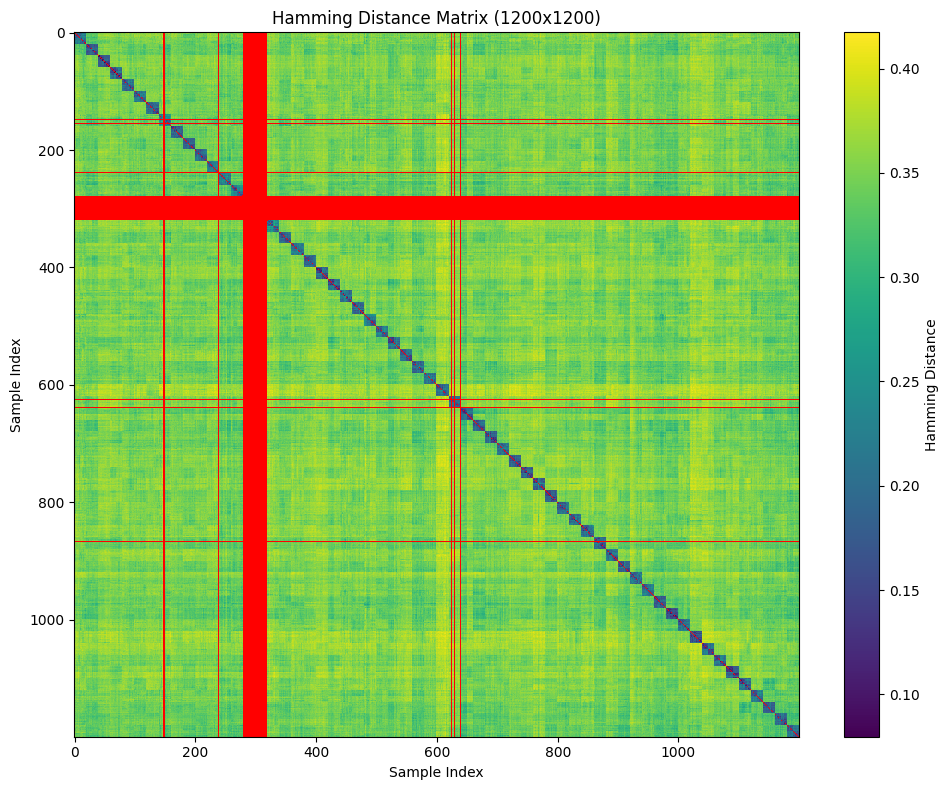

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the matrix
distance_matrix = np.load("./hamming_matrices/(8x128).npy")

# Mask invalid entries (NaNs) for better visualization
masked_matrix = np.ma.masked_invalid(distance_matrix)

plt.figure(figsize=(10, 8))
cmap = plt.cm.viridis
cmap.set_bad(color='red')  # Show invalid comparisons in red

# Plot heatmap
im = plt.imshow(masked_matrix, cmap=cmap, interpolation='nearest', aspect='auto')
plt.colorbar(im, label="Hamming Distance")

plt.title("Hamming Distance Matrix (1200x1200)")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()


Find optimum threshold with EER Calculation

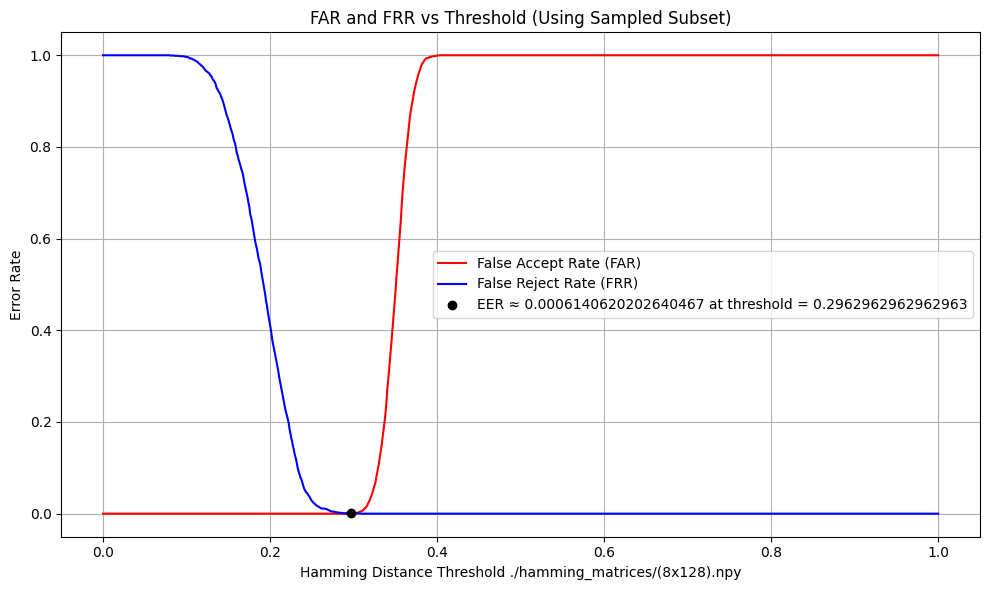

✅ Best threshold (EER) ≈ 0.2962962962962963 with EER ≈ 0.0006140620202640467


In [2]:
#### Hamming Distance Analysis with EER Calculation ####

import numpy as np
import matplotlib.pyplot as plt

FILENAME = "./hamming_matrices/(8x128).npy"

# Load distance matrix
distance_matrix = np.load(FILENAME)
n = distance_matrix.shape[0]

# Create class labels (20 samples per class)
labels = np.array([i // 20 for i in range(n)])

# Collect pairwise distances and labels (only upper triangle)
matched = []
unmatched = []

for i in range(n):
    for j in range(i + 1, n):  # <== Only upper triangle
        dist = distance_matrix[i, j]
        if np.isnan(dist):
            continue
        if labels[i] == labels[j]:
            matched.append((dist, 1))
        else:
            unmatched.append((dist, 0))

# Randomly sample 30% of matched pairs
np.random.seed(42)  # For reproducibility
matched = np.array(matched)
unmatched = np.array(unmatched)

num_matched = int(len(matched) * 0.3)
sampled_matched = matched[np.random.choice(len(matched), size=num_matched, replace=False)]

# Sample equal number of unmatched pairs
sampled_unmatched = unmatched[np.random.choice(len(unmatched), size=num_matched, replace=False)]

# Combine and shuffle
sampled_all = np.vstack([sampled_matched, sampled_unmatched])
np.random.shuffle(sampled_all)

dists = sampled_all[:, 0].astype(float)
truths = sampled_all[:, 1].astype(int)

# === Compute FAR and FRR ===
thresholds = np.linspace(0, 1, 1000)
FAR, FRR = [], []

for t in thresholds:
    predictions = dists < t
    false_accepts = np.sum((predictions == 1) & (truths == 0))
    false_rejects = np.sum((predictions == 0) & (truths == 1))
    total_impostor = np.sum(truths == 0)
    total_genuine = np.sum(truths == 1)

    far = false_accepts / total_impostor if total_impostor else 0
    frr = false_rejects / total_genuine if total_genuine else 0

    FAR.append(far)
    FRR.append(frr)

FAR = np.array(FAR)
FRR = np.array(FRR)
diff = np.abs(FAR - FRR)
eer_index = np.argmin(diff)
eer_threshold = thresholds[eer_index]
eer = (FAR[eer_index] + FRR[eer_index]) / 2

# === Plotting ===
plt.figure(figsize=(10, 6))
plt.plot(thresholds, FAR, label="False Accept Rate (FAR)", color="red")
plt.plot(thresholds, FRR, label="False Reject Rate (FRR)", color="blue")
plt.plot(eer_threshold, eer, 'ko', label=f"EER ≈ {eer} at threshold = {eer_threshold}")
plt.xlabel(f"Hamming Distance Threshold {FILENAME}")
plt.ylabel("Error Rate")
plt.title("FAR and FRR vs Threshold (Using Sampled Subset)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ Best threshold (EER) ≈ {eer_threshold} with EER ≈ {eer}")


Evaluate confusion matrix

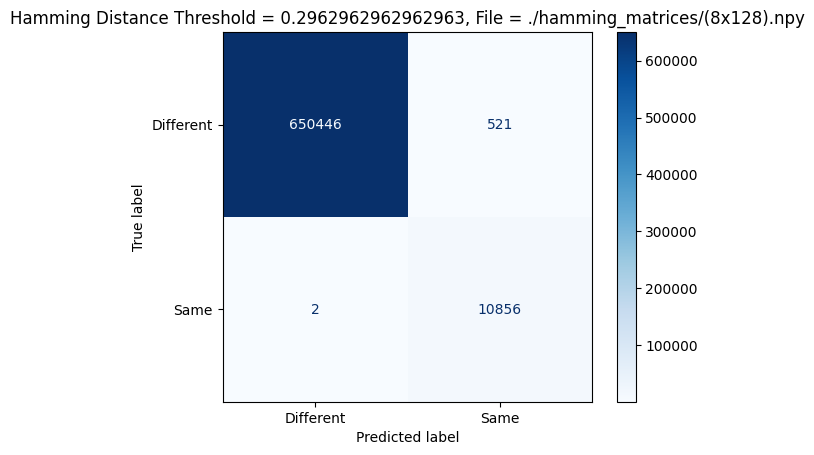

=== Evaluation Metrics (TH=0.2962962962962963) , File = ./hamming_matrices/(8x128).npy===
Accuracy       : 0.9992097608884524
Precision      : 0.954205853915795
Recall         : 0.9998158040154724
F1 Score       : 0.9764785248482123
False Accept Rate (FAR): 0.0008003477902873725
False Reject Rate (FRR): 0.0001841959845275373

Classification Report:
              precision    recall  f1-score   support

   Different       1.00      1.00      1.00    650967
        Same       0.95      1.00      0.98     10858

    accuracy                           1.00    661825
   macro avg       0.98      1.00      0.99    661825
weighted avg       1.00      1.00      1.00    661825



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

FILENAME = "./hamming_matrices/(8x128).npy"

# Load distance matrix and create labels
distance_matrix = np.load(FILENAME)
n = distance_matrix.shape[0]
labels = np.array([i // 20 for i in range(n)])

y_true = []
y_pred = []

threshold = 0.2962962962962963 

# Generate predictions and ground truth
for i in range(n):
    for j in range(i + 1, n):
        dist = distance_matrix[i, j]
        if np.isnan(dist):
            continue
        same_class = int(labels[i] == labels[j])  # 1 if same person, else 0
        prediction = int(dist < threshold)
        y_true.append(same_class)
        y_pred.append(prediction)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Different", "Same"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Hamming Distance Threshold = {threshold}, File = {FILENAME}")
plt.show()

# Compute standard metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Custom: FAR and FRR
TN, FP, FN, TP = cm.ravel()
far = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Accept Rate
frr = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Reject Rate

# Print all metrics
print(f"=== Evaluation Metrics (TH={threshold}) , File = {FILENAME}===")
print(f"Accuracy       : {acc}")
print(f"Precision      : {prec}")
print(f"Recall         : {rec}")
print(f"F1 Score       : {f1}")
print(f"False Accept Rate (FAR): {far}")
print(f"False Reject Rate (FRR): {frr}")
print()
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Different", "Same"]))
